In [66]:
import pandas as pd
import re
import numpy as np
from scipy import stats

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime

from math import floor

# Purpose

This notebook is meant to practice analyzing one VA station at a time.

 

# The Data

In [67]:
master = pd.read_csv("Data/Master/Master.csv",dtype={'Station': str})
df = master
Diego = df[df["Station"] == "664"]# San Diego
Linda = df[df["Station"] == "605"]# Loma Linda, CA
LA = df[df["ID"] == "691gr"]# LA, CA
df.head()

,Appts_Pending_1412,%_Appts_Over_30_Pending_1412,PC_Wait_Pending_1412,SC_Wait_Pending_1412,MH_Wait_Pending_1412,for_dups,ORGANIZATION,MAY-FY11,MAY-FY12,MAY-FY13,...,Staff_To_Appts_Pending_16,Staff_To_Appts_Complete_14,Staff_To_Appts_Complete_16,Percentage_Point_Wait_Over_30_Increase_Pending,Percentage_Point_Wait_Over_30_Increase_Complete,qualitative_size,State_Full,Vet_Pop_State_9_30_14,Vet_Pop_State_9_30_34,Vet_Pop_State_Increase_20
0,42899,2.70,2.51,4.07,2.77,402,(V01) (402) HCS TOGUS ME,1293.0,1272.0,1248.0,...,30.158368,19.063133,19.836100,1.48,-0.33,average,Maine ...,127234.0,88339.0,-38895.0
1,23709,2.16,3.92,3.95,0.79,405,(V01) (405) MROC WHT RIVER JCT VT,852.0,853.0,881.0,...,17.919286,20.881650,18.335599,1.67,0.19,average,Vermont ...,48602.0,32123.0,-16479.0
2,8105,5.17,1.12,10.53,4.41,518,(V01) (518) MC BEDFORD MA,1313.0,1265.0,1245.0,...,10.692308,9.573141,9.741124,2.37,-0.44,average,Massachusetts,379772.0,202167.0,-177605.0
3,85625,1.71,1.66,3.53,3.92,523,(V01) (523) HCS BOSTON MA,4022.0,4011.0,4041.0,...,19.607948,11.326637,10.761329,2.72,1.66,large,Massachusetts,379772.0,202167.0,-177605.0
4,19511,2.64,2.66,4.21,5.13,608,(V01) (608) MC MANCHESTER NH,663.0,683.0,691.0,...,31.661270,25.679300,23.473225,1.45,-0.03,small,New Hampshire ...,113660.0,73499.0,-40161.0


# Functions

In [68]:
# Marks where in a histogram the station is located. 
# Code belongs to Tony Babarino from stackoverflow.com.
# http://stackoverflow.com/questions/35890738/change-the-colour-of-a-matplotlib-histogram-bin-bar-given-a-value

def marked_hist(column,new_ax):
    p = df[column].plot(kind="hist", color='teal',bins=30, ax=new_ax)
    bar_value_to_label = float(Station[column].to_string(index=False))
    min_distance = float("inf")
    index_of_bar_to_label = 0
    for i, rectangle in enumerate(p.patches):  # iterate over every bar
        tmp = abs(  # tmp = distance from middle of the bar to bar_value_to_label
            (rectangle.get_x() +
                (rectangle.get_width() * (1 / 2))) - bar_value_to_label)
        if tmp < min_distance:  # we are searching for the bar with x cordinate
                                # closest to bar_value_to_label
            min_distance = tmp
            index_of_bar_to_label = i
            
    x = Station[column].to_string(index=False)
    if x != 'NaN':
        p.patches[index_of_bar_to_label].set_color('red')
        
def std_distance(factor):
    std = df[factor].std()
    mean = df[factor].mean()
    return "{}: {}".format(factor,str((Station[factor].item()-mean)/std))

def std_distance_raw(factor):
    std = df[factor].std()
    mean = df[factor].mean()
    return (mean - Station[factor].item())/std

### Pending percent increase

In [69]:
factors = ["PC_Wait_Pending_Increase_%","PC_Wait_Complete_Increase_%","SC_Wait_Pending_Increase_%",
           "PC_Wait_Complete_Increase_%","SC_Wait_Pending_Increase_%","MH_Wait_Pending_Increase_%",
           "Pending_Increase_%","Complete_Increase_%","Choice_Increase_%",
           "Physician_Turnover_FY11","Physician_Turnover_FY12","Physician_Turnover_FY13",
          "Physician_Turnover_FY14","Physician_Turnover_FY15",
           'Staff_11_To_12_Increase_%','Staff_12_To_13_Increase_%','Staff_13_To_14_Increase_%',
           'Staff_14_To_15_Increase_%','Staff_15_To_16_Increase_%',
           "Complete_Pending_Gap_Increase_%",
          "PC_Wait_Complete_1409","PC_Wait_Complete_1608","PC_Wait_Pending_1412","PC_Wait_Pending_1610",
          "Choice_Increase_%_PC_Wait_Pending_1412_Ratio","Choice_Increase_%_PC_Wait_Complete_1409_Ratio",
          "MH_Wait_Complete_1409","MH_Wait_Complete_1608","MH_Wait_Pending_1412","MH_Wait_Pending_1610",
          "SC_Wait_Complete_1409","SC_Wait_Complete_1608","SC_Wait_Pending_1412","SC_Wait_Pending_1610",
          "Complete_Pending_Gap_Increase_%","Staff_To_Appts_Complete_14","Staff_To_Appts_Complete_16"]

def interest_metric(x):
    interest = {}
    for factor in factors:
        std = df[factor].std()
        mean = df[factor].mean()
        distance = (x[factor] - mean)/std
        interest[factor] = distance
    return interest


#Station = df[df["Station"] == "573"]#Gainesville
#Station = df[df["Station"] == "358"]
#Station = df[df["Station"] == "504"]
#Station = df[df["Station"] == "664"]# San Diego
#Station = df[df["Station"] == "605"]# Loma Linda, CA
Station = df[df["ID"] == "691gr"]# LA, CA
#Station = df[df["Station"] == "600"]
#Station = df[df["Station"] == "459"]
#Station = df[df["Station"] == "675"]#Orlando
#Station = df[df["for_dups"] == "674"]











#Station = df[df["Station"] == "663"]# Seattle, WA
#Station = df[df["Station"] == "668"]# Spokane, WA
#Station = df[df["Station"] == "687"]# Walla Walla, WA



# see how many standard deviations each factor is from the mean
station_std = interest_metric(Station)
standard_columns = ["Station","Location"]
extra_columns = ["MH_Wait_Pending_Increase_%","MH_Wait_Complete_Increase_%",'Choice_Hires','Choice_Increase_%','Staff_14_To_16_Increase']
interesting_angles = []
for key in station_std:
    if station_std[key].item() >= 1:
        interesting_angles.append(key)
        print key
    if station_std[key].item() >= 2:
        print "***Big angle! {}***".format(key)
Station[standard_columns+interesting_angles+extra_columns]  


MH_Wait_Complete_1608
PC_Wait_Pending_1610
SC_Wait_Pending_1412
SC_Wait_Pending_1610
MH_Wait_Complete_1409
Choice_Increase_%_PC_Wait_Complete_1409_Ratio


,Station,Location,MH_Wait_Complete_1608,PC_Wait_Pending_1610,SC_Wait_Pending_1412,SC_Wait_Pending_1610,MH_Wait_Complete_1409,Choice_Increase_%_PC_Wait_Complete_1409_Ratio,MH_Wait_Pending_Increase_%,MH_Wait_Complete_Increase_%,Choice_Hires,Choice_Increase_%,Staff_14_To_16_Increase
131,691,(V22) (691) Greater Los Angeles HCS,4.24,10.48,13.35,15.2,4.49,2.165763,29.876161,-5.567929,108.0,2.142432,49.0


In [70]:
#Diego["MH_Wait_Complete_1608"]

In [71]:
Station[["Appts_Pending_1412","Appts_Pending_1610","Appts_Complete_1409","Appts_Complete_1608"]]

,Appts_Pending_1412,Appts_Pending_1610,Appts_Complete_1409,Appts_Complete_1608
131,80701,89208,65683,70257


In [72]:
type(df["Station"][0])

str

In [73]:
Station["Choice_Hires"]

131    108.0
Name: Choice_Hires, dtype: float64

In [74]:
Diego["MH_Wait_Complete_1608"]

130    5.38
Name: MH_Wait_Complete_1608, dtype: float64

In [75]:
Factor = ["Choice_Hires"]
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego:      Choice_Hires
130         144.0
LA:      Choice_Hires
131         108.0


In [76]:
Factor = ["Staff_14_To_16_Increase"]
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego:      Staff_14_To_16_Increase
130                    145.0
LA:      Staff_14_To_16_Increase
131                     49.0


In [77]:
Factor = ["MAY-FY14"]
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego:      MAY-FY14
130    3028.0
LA:      MAY-FY14
131    5041.0


In [78]:
Factor = ["MAY-FY15"]
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego:      MAY-FY15
130    3158.0
LA:      MAY-FY15
131    5137.0


In [79]:
Factor = ["MAY-FY16"]
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego:      MAY-FY16
130    3173.0
LA:      MAY-FY16
131    5090.0


In [80]:
Factor = "Appts_Complete_1409"
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego: 130    60802
Name: Appts_Complete_1409, dtype: int64
LA: 131    65683
Name: Appts_Complete_1409, dtype: int64


In [81]:
Factor = "Appts_Complete_1608"
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego: 130    60297
Name: Appts_Complete_1608, dtype: int64
LA: 131    70257
Name: Appts_Complete_1608, dtype: int64


In [82]:
Factor = "MH_Wait_Complete_1409"
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego: 130    3.0
Name: MH_Wait_Complete_1409, dtype: float64
LA: 131    4.49
Name: MH_Wait_Complete_1409, dtype: float64


In [83]:
Factor = "MH_Wait_Complete_1608"
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego: 130    5.38
Name: MH_Wait_Complete_1608, dtype: float64
LA: 131    4.24
Name: MH_Wait_Complete_1608, dtype: float64


In [84]:
Factor = ["Physician_Turnover_FY15"]
print "Diego: {}".format(Diego[Factor])
print "LA: {}".format(Station[Factor])

Diego:      Physician_Turnover_FY15
130                     7.21
LA:      Physician_Turnover_FY15
131                     7.96


In [85]:
Station = df[df["Station"] == "600"]

In [86]:
Station

,Appts_Pending_1412,%_Appts_Over_30_Pending_1412,PC_Wait_Pending_1412,SC_Wait_Pending_1412,MH_Wait_Pending_1412,for_dups,ORGANIZATION,MAY-FY11,MAY-FY12,MAY-FY13,...,Staff_To_Appts_Pending_16,Staff_To_Appts_Complete_14,Staff_To_Appts_Complete_16,Percentage_Point_Wait_Over_30_Increase_Pending,Percentage_Point_Wait_Over_30_Increase_Complete,qualitative_size,State_Full,Vet_Pop_State_9_30_14,Vet_Pop_State_9_30_34,Vet_Pop_State_Increase_20
128,49174,3.33,8.78,3.75,3.86,600,(V22) (600) HCS LONG BEACH CA,2308.0,2358.0,2343.0,...,19.345604,20.942397,21.037527,4.98,0.51,average,California,1851470.0,1150965.0,-700505.0


# Extracting Interesting Columns

[128    (V22) (600) Long Beach, CA
Name: Location, dtype: object]


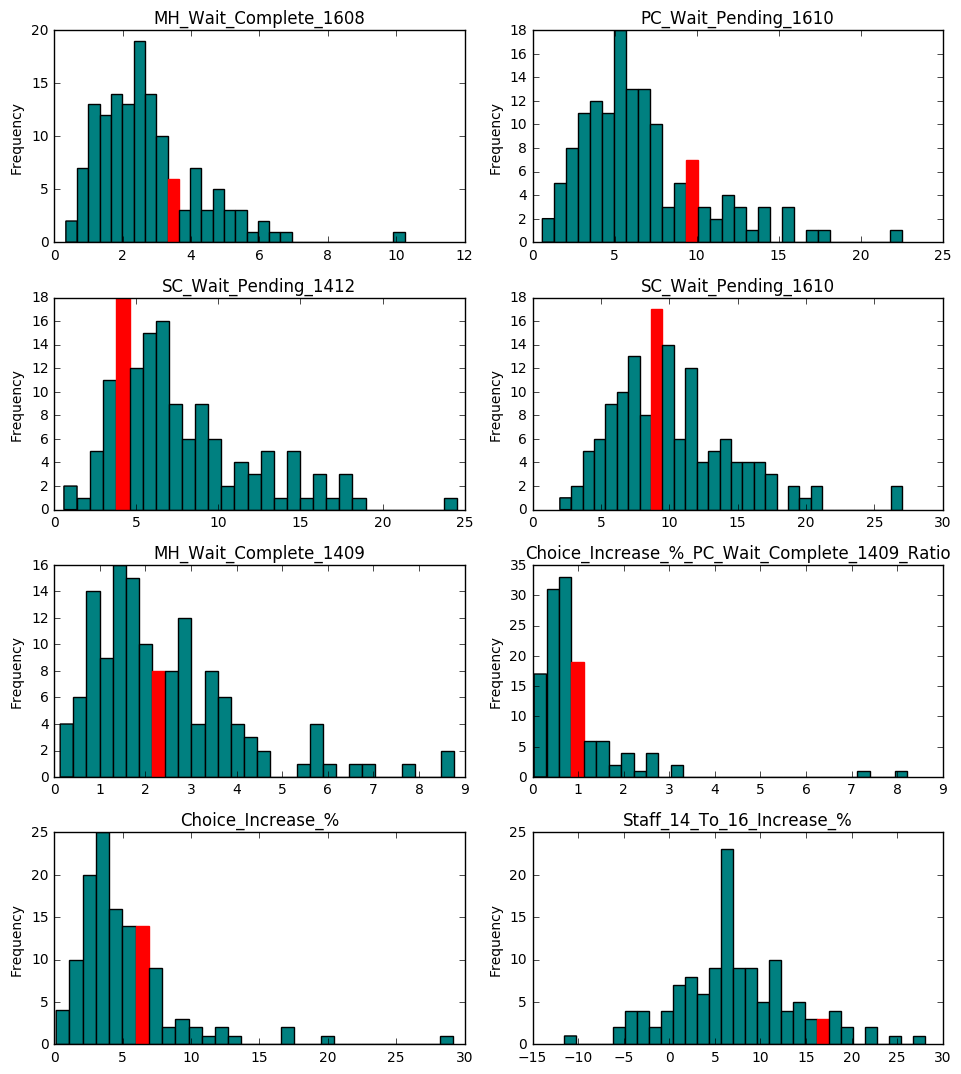

In [87]:
# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=6, ncols=2,figsize=(10,16))
axes_list = [item for sublist in axes for item in sublist] 

interesting_angles.append("Choice_Increase_%")
interesting_angles.append("Staff_14_To_16_Increase_%")
for factor in interesting_angles:
    ax = axes_list.pop(0)
    ax.set_title(factor)
    marked_hist(factor,ax)


# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()
print[Station["Location"]]

In [88]:
Station["Staff_14_To_16_Increase_%"]

128    15.618299
Name: Staff_14_To_16_Increase_%, dtype: float64

In [89]:
Station["Location"]

128    (V22) (600) Long Beach, CA
Name: Location, dtype: object

In [90]:
df["Staff_14_To_16_Increase_%"].mean()

7.2282250095985789

In [91]:
df["MAY-FY14"].mean()

2083.9453125

#fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,16))

#marked_hist("Staff_To_Appts_Complete_16",ax)

128    (V22) (600) Long Beach, CA
Name: Location, dtype: object


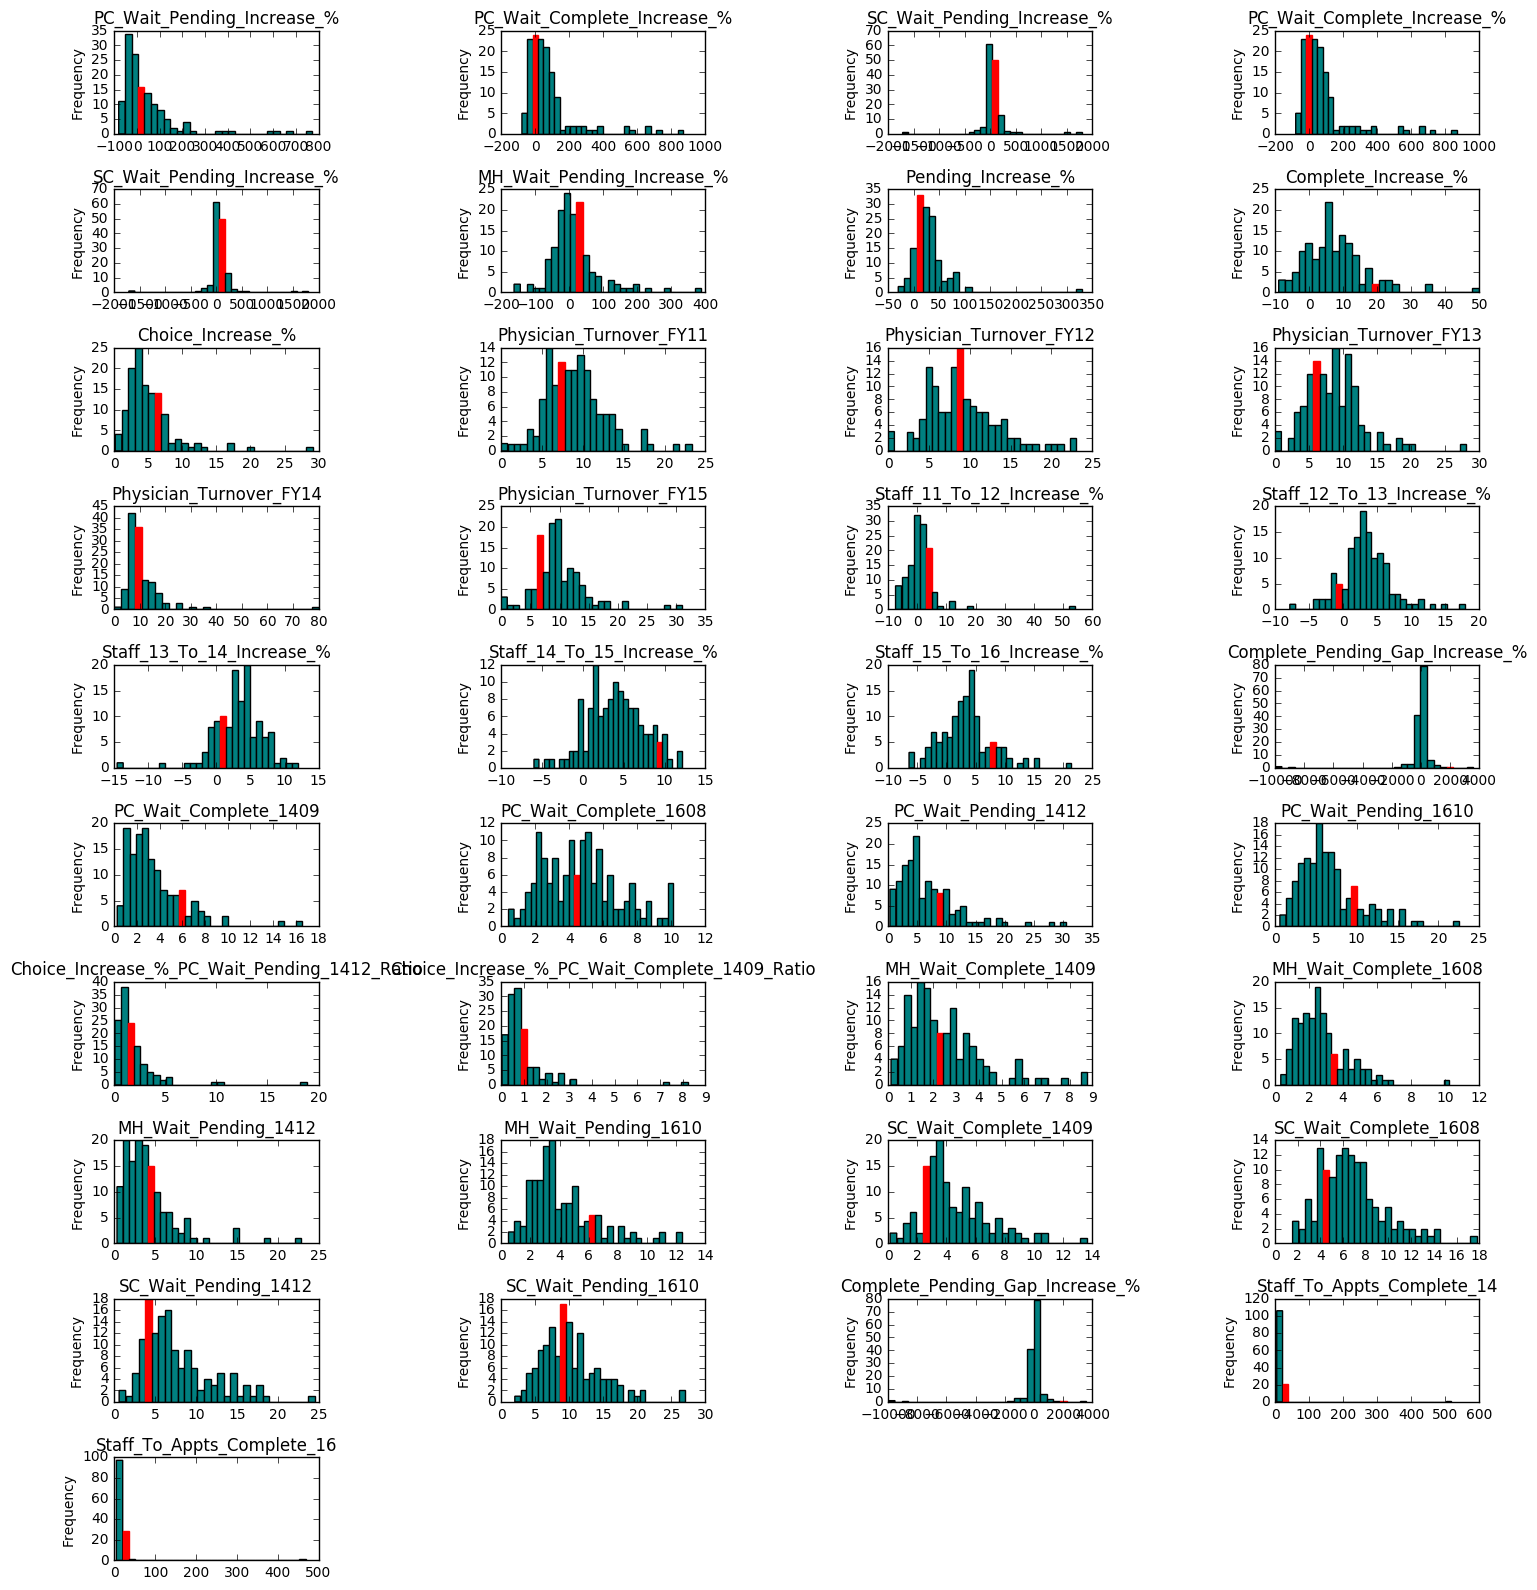

In [92]:
# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=10, ncols=4,figsize=(15,16))
axes_list = [item for sublist in axes for item in sublist] 

for factor in factors:
    ax = axes_list.pop(0)
    ax.set_title(factor)
    marked_hist(factor,ax)


# Now use the matplotlib .remove() method to 
# delete anything we didn't use
print Station["Location"]
for ax in axes_list:
    ax.remove()

plt.tight_layout()

In [93]:

print "================\nWait Times\n"
print std_distance('PC_Wait_Pending_Increase_%')
print std_distance('PC_Wait_Complete_Increase_%')
print std_distance('SC_Wait_Pending_Increase_%')
print std_distance('SC_Wait_Complete_Increase_%')
print std_distance('MH_Wait_Pending_Increase_%')
print std_distance('MH_Wait_Complete_Increase_%')
print "================\nAppointments\n"
print std_distance("Pending_Increase_%")
print std_distance("Complete_Increase_%")
print std_distance("Complete_Pending_Gap_Increase_%")

print "================\nChoice Hires\n"
print std_distance("Choice_Increase_%")
print std_distance("Choice_Increase_%_PC_Wait_Complete_1409_Ratio")
print "================\nPhysician Turnover\n"
print std_distance("Physician_Turnover_FY11")
print std_distance("Physician_Turnover_FY12")
print std_distance("Physician_Turnover_FY13")
print std_distance("Physician_Turnover_FY14")
print std_distance("Physician_Turnover_FY15")
print "================\nStaff Increase\n"
print std_distance('Staff_11_To_12_Increase_%')
print std_distance('Staff_12_To_13_Increase_%')
print std_distance('Staff_13_To_14_Increase_%')
print std_distance('Staff_14_To_15_Increase_%')
print std_distance('Staff_15_To_16_Increase_%')

Wait Times

PC_Wait_Pending_Increase_%: -0.272309085179
PC_Wait_Complete_Increase_%: -0.693477296655
SC_Wait_Pending_Increase_%: -0.0239836792952
SC_Wait_Complete_Increase_%: -0.108418921111
MH_Wait_Pending_Increase_%: 0.173434272198
MH_Wait_Complete_Increase_%: -0.0677968119007
Appointments

Pending_Increase_%: -0.544961203579
Complete_Increase_%: 1.30134606735
Complete_Pending_Gap_Increase_%: 1.40526496763
Choice Hires

Choice_Increase_%: 0.188226957269
Choice_Increase_%_PC_Wait_Complete_1409_Ratio: -0.0124337911067
Physician Turnover

Physician_Turnover_FY11: -0.544274221741
Physician_Turnover_FY12: -0.131554796426
Physician_Turnover_FY13: -0.767754357787
Physician_Turnover_FY14: -0.393428554088
Physician_Turnover_FY15: -0.837643001577
Staff Increase

Staff_11_To_12_Increase_%: 0.164131748947
Staff_12_To_13_Increase_%: -1.09986232766
Staff_13_To_14_Increase_%: -0.67484541386
Staff_14_To_15_Increase_%: 1.44824069776
Staff_15_To_16_Increase_%: 0.828932382326


# To Delete

In [94]:
Station["NbrPsychiatrists"]

128    7.0
Name: NbrPsychiatrists, dtype: float64

In [95]:
Station["MH_Wait_Complete_1608"]

128    3.27
Name: MH_Wait_Complete_1608, dtype: float64

In [96]:
Diego = df[df["Station"] == "664"]# San Diego
Diego["MH_Wait_Complete_1608"]

130    5.38
Name: MH_Wait_Complete_1608, dtype: float64

In [97]:
Beach = df[df["Station"] == "600"]
Beach["MH_Wait_Complete_1608"]

128    3.27
Name: MH_Wait_Complete_1608, dtype: float64

In [98]:
df.columns

Index([u'Appts_Pending_1412', u'%_Appts_Over_30_Pending_1412',
       u'PC_Wait_Pending_1412', u'SC_Wait_Pending_1412',
       u'MH_Wait_Pending_1412', u'for_dups', u'ORGANIZATION', u'MAY-FY11',
       u'MAY-FY12', u'MAY-FY13',
       ...
       u'Staff_To_Appts_Pending_16', u'Staff_To_Appts_Complete_14',
       u'Staff_To_Appts_Complete_16',
       u'Percentage_Point_Wait_Over_30_Increase_Pending',
       u'Percentage_Point_Wait_Over_30_Increase_Complete', u'qualitative_size',
       u'State_Full', u'Vet_Pop_State_9_30_14', u'Vet_Pop_State_9_30_34',
       u'Vet_Pop_State_Increase_20'],
      dtype='object', length=103)

In [99]:
Station["Choice_Increase_%"]

128    5.929691
Name: Choice_Increase_%, dtype: float64

In [100]:
df["Choice_Increase_%"].describe()

count    127.000000
mean       5.200187
std        3.875663
min        0.141176
25%             NaN
50%             NaN
75%             NaN
max       29.166667
Name: Choice_Increase_%, dtype: float64

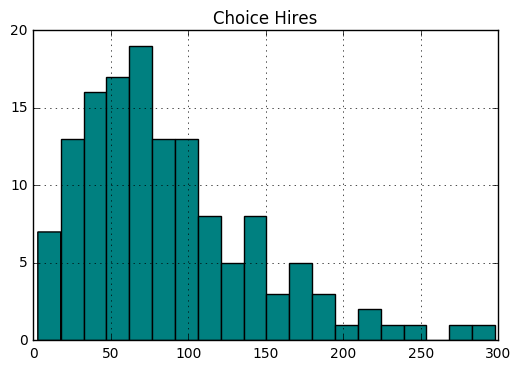

In [101]:
ax = df["Choice_Hires"].hist(color="teal",bins=20)
ax.set_title("Choice Hires")